# Statistical Inference on the Stock Market
##### Group 6: Kaylie Nguyen, Chi Pham, Rohan Shan, Max Xu

In [1]:
library(tidyverse)
library(repr)
library(datateachr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(stringi)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Introduction

Over the past few years, there has been a high level of inflation. The ideal annual inflation rate according to central banks across the world is 2%. However, throughout 2022, the inflation rate in the United States has been consistently above 7% (above 8% since March). This is due to excess government stimulus, and supply chain issues businesses have been facing since the onset of the COVID-19 pandemic. 

To combat this, the US Federal Reserve has increased its interest rate from 0% all the way to 4% as of November 2022. Despite this, the interest rate is still below the inflation rate, therefore the real interest rate is still negative. Because of this many companies' profits have been hurt by higher costs of production and interest costs. Nevertheless, some companies that produce raw materials (commodities) have seen their revenue increase at a much faster rate than their cost of production. This leads us to the question: Does the U.S. raw material industry outperform the rest of the U.S. market during times of high inflation?

We will begin by dividing up the companies listed in the NYSE Arca, NYSE, and NASDAQ by raw material, and non-raw material industries respectively and taking a sample of both. Then, we will create a bootstrap distribution for each as well as a side-by-side boxplot. After that, we will do a hypothesis test to compare the mean of the yearly performance rate in both sets of samples to make our conclusion. 


## Preliminary Results

First, we will read the dataset that has already been downloaded from the website at a specific time as the data on the website is time sensitive: the data is updated every 10 seconds. The version we're using was downloaded on Oct 30th, 2022 at 3:41pm.

Dataset Download Link: https://drive.google.com/file/d/1uuD1eR6Y-Soys26rkYw6DP6LJyTGDxyD/view

In [2]:
df <- read.csv("america_2022-10-30-2.csv")
head(df)

,Ticker,Description,Price,Market.Capitalization,Enterprise.Value..MRQ.,Free.Cash.Flow..Annual.YoY.Growth.,EBITDA..Annual.YoY.Growth.,EPS.Diluted..Annual.YoY.Growth.,Gross.Profit..Annual.YoY.Growth.,Net.Income..Annual.YoY.Growth.,Yearly.Performance,Monthly.Performance,Change..,Gross.Margin..TTM.,Operating.Margin..TTM.,Pretax.Margin..TTM.,Net.Margin..TTM.,Industry
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AAPL,Apple Inc.,155.74,2.477530e+12,2.50888e+12,19.891773,8.573353,8.892056,11.74200,5.410858,3.951408,5.4863181,12.6917511,43.30963,30.288744,30.204043,25.309641,Telecommunications Equipment
2,MSFT,Microsoft Corporation,235.87,1.758287e+12,1.71313e+12,16.092876,21.068848,19.786428,17.05911,18.715216,-27.273568,-0.3969427,1.2752254,68.26000,41.690508,41.740244,34.366121,Packaged Software
3,GOOG,Alphabet Inc.,96.58,1.248046e+12,1.25745e+12,56.412950,66.239223,91.418432,50.12498,88.812734,-34.432685,-1.4690879,0.4472179,55.86563,27.465095,28.003549,23.872310,Internet Software/Services
4,AMZN,"Amazon.com, Inc.",103.41,1.054953e+12,1.25309e+12,-156.804505,22.212676,54.889303,29.27591,56.410857,-39.208047,-9.5908376,-8.4867257,43.04438,2.688021,1.983309,2.254720,Internet Retail
5,TSLA,"Tesla, Inc.",228.52,7.216096e+11,9.05545e+11,83.806713,117.956441,667.843691,105.21870,700.579710,-35.827251,-19.2737036,-13.8473139,26.61261,16.710525,16.524852,14.936618,Motor Vehicles
6,BRK.A,Berkshire Hathaway Inc.,451900.00,6.671907e+11,6.29393e+11,-2.301857,12.738163,122.963852,13.07806,111.178006,3.956099,11.8196929,11.1767166,19.72554,13.559755,4.411983,4.041525,Multi-Line Insurance


In [3]:
#selects only the Industry column so we can manually look up the names of the raw material industries
#After picking the raw material industry names, we display only the first few rows of the names for better readability
head(unique(df["Industry"]))

,Industry
,<chr>
1,Telecommunications Equipment
2,Packaged Software
3,Internet Software/Services
4,Internet Retail
5,Motor Vehicles
6,Multi-Line Insurance


In [4]:
# Names of the Raw Material Industries
raw_material_industries <- c("Agricultural Commodities/Milling", "Aluminum", "Chemicals: Agricultural", "Chemicals: Major Diversified", "Chemicals: Specialty",
                 "Coal", "Food Distributors", "Food: Major Diversified", "Food: Meat/Fish/Dairy", "Forest Products", "Gas Distributors",
                 "Integrated Oil", "Oil & Gas Pipelines", "Oil & Gas Production", "Oil Refining/Marketing", "Other Metals/Minerals", "Precious Metals",
                 "Steel", "Textiles", "Tobacco", "Water Utilities")

# Add new column to identify whether an industry does raw material and select necessary columns only
df <- df %>%
    select(Ticker, Yearly.Performance, Industry) %>%
    mutate(Raw_material = if_else(Industry %in% raw_material_industries, 
                                  TRUE, 
                                  FALSE))

colnames(df) <- tolower(colnames(df))
head(df)

,ticker,yearly.performance,industry,raw_material
,<chr>,<dbl>,<chr>,<lgl>
1,AAPL,3.951408,Telecommunications Equipment,FALSE
2,MSFT,-27.273568,Packaged Software,FALSE
3,GOOG,-34.432685,Internet Software/Services,FALSE
4,AMZN,-39.208047,Internet Retail,FALSE
5,TSLA,-35.827251,Motor Vehicles,FALSE
6,BRK.A,3.956099,Multi-Line Insurance,FALSE


[1] 38

[1] 509

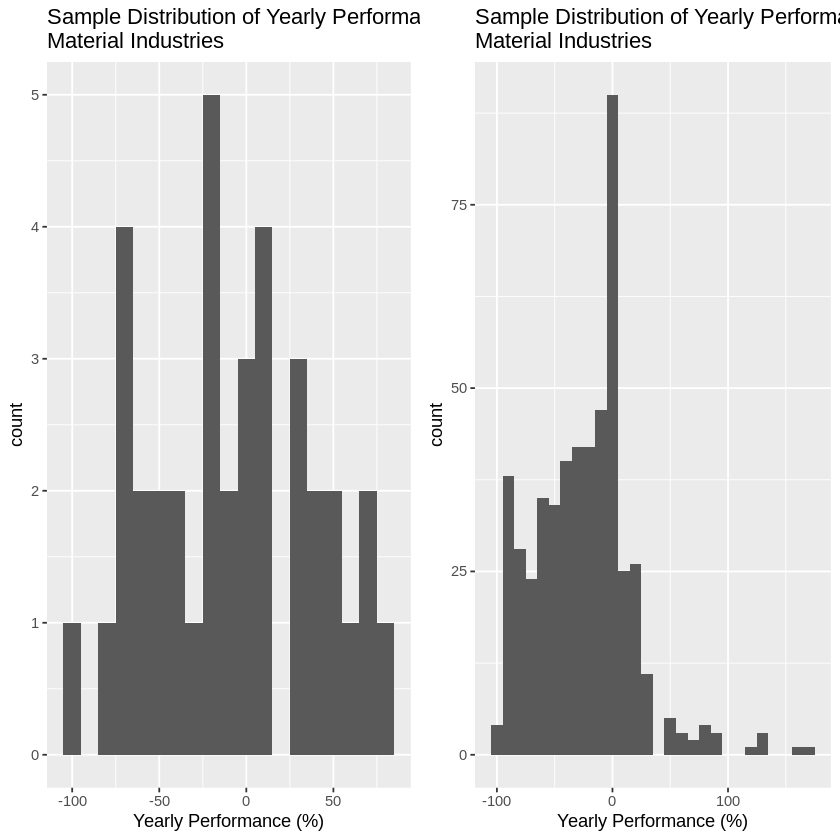

In [5]:
set.seed(9284)

# Dataset of raw materials industries
rmc <- df %>%
        filter(raw_material) %>%
        select(-raw_material)

# Dataset of the rest of the market
nrmc <- df %>%
        filter(!raw_material) %>%
        select(-raw_material)

#10% of the population size of raw material industries
rmc_sample_size<-ceiling(nrow(rmc)*0.1)
rmc_sample_size

#10% of the population size of the rest of the market 
nrmc_sample_size<-ceiling(nrow(nrmc)*0.1)
nrmc_sample_size

#Single random sample of raw material industries
rmc_sample <- rmc |> 
    rep_sample_n(size = rmc_sample_size, replace = FALSE) %>% 
    ungroup() |>
    select(yearly.performance)

#Single random sample of the rest of the market
nrmc_sample <- nrmc |> 
    rep_sample_n(size = nrmc_sample_size, replace = FALSE) %>% 
    ungroup() |>
    select(yearly.performance)

#Plotting Sample distribution of sample
rmc_sample_dist <- rmc_sample |>
    ggplot(aes(x = yearly.performance)) +
    geom_histogram(binwidth=10) +
    xlab("Yearly Performance (%)") +
    ggtitle("Sample Distribution of Yearly Performance for Raw Material Industries")

#Plotting Sample distribution of sample
nrmc_sample_dist <- nrmc_sample |>
    ggplot(aes(x = yearly.performance)) +
    geom_histogram(binwidth=10) +
    xlab("Yearly Performance (%)") +
    ggtitle("Sample Distribution of Yearly Performance for Non-Raw Material Industries")

#Side-by-side plot
plot_grid(rmc_sample_dist +
              labs(title = "Sample Distribution of Yearly Performance for Raw \nMaterial Industries",
                   xlab = "Yearly Performance (%)"),
          nrmc_sample_dist +
              labs(title = "Sample Distribution of Yearly Performance for Non-Raw \nMaterial Industries",
                   xlab = "Yearly Performance (%)"))

In the cell above, we've separated the original dataset into 2 sub-datasets: one including the examples of the raw material industries and one including the rest of the market. Since the dataset contains data of large public companies that make up a major share of the market, we consider this as having access to the whole population in our problem and take 2 samples each of 10% of the size of the respective population: the raw market industries and the rest of the market. The distribution of the samples are displayed above.

In [6]:
# Mean yearly performance for a single sample of raw material industries and rest of the market
sample_dfboth <- rbind(cbind(data = "Raw Material Industries", rmc_sample),
  cbind(data = "Rest of the market", nrmc_sample))
sample_summary <- sample_dfboth %>%
    group_by(data)%>%
    summarize(f_mean = mean(yearly.performance))

sample_summary

data,f_mean
<chr>,<dbl>
Raw Material Industries,-9.152618
Rest of the market,-24.401879


We then proceed with bootstrap sampling for the 2 samples in order to estimate and study the sampling distributions.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



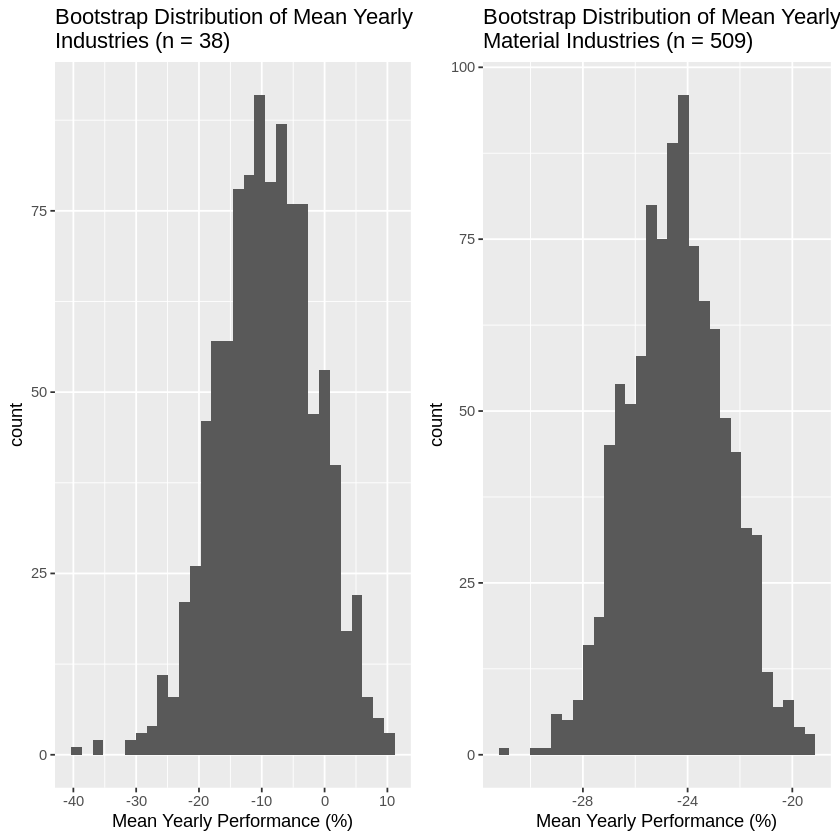

In [7]:
set.seed(9284)

#Bootstrapping, calculating mean yearly performance
rmc_bootstrap <- rmc_sample %>% 
    rep_sample_n(size = rmc_sample_size, reps = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean = mean(yearly.performance)) 

#Plotting bootstrap distribution
rmc_bootstrap_dist <- rmc_bootstrap |>
    ggplot(aes(x = mean)) +
    geom_histogram() +
    xlab("Mean Yearly Performance (%)") +
    ggtitle("Bootstrap Distribution of Mean Yearly Performance for Raw Material Industries (n = 38)")

#Bootstrapping, calculating mean yearly performance
nrmc_bootstrap<- nrmc_sample %>% 
    rep_sample_n(size = nrmc_sample_size, reps = 1000, replace = TRUE) %>% 
    group_by(replicate) %>% 
    summarize(mean = mean(yearly.performance)) 

#Plotting bootstrap distribution
nrmc_bootstrap_dist <- nrmc_bootstrap |>
    ggplot(aes(x = mean)) +
    geom_histogram() +
    xlab("Mean Yearly Performance (%)") +
    ggtitle("Bootstrap Distribution of Mean Yearly Performance for Non-Raw Material Industries (n = 509)")

#Side-by-side plot
plot_grid(rmc_bootstrap_dist +
              labs(title = "Bootstrap Distribution of Mean Yearly Performance for Raw Material \nIndustries (n = 38)",
                   xlab = "Mean Yearly Performance (%)"),
          nrmc_bootstrap_dist +
              labs(title = "Bootstrap Distribution of Mean Yearly Performance for Non-Raw \nMaterial Industries (n = 509)",
                   xlab = "Mean Yearly Performance (%)"))


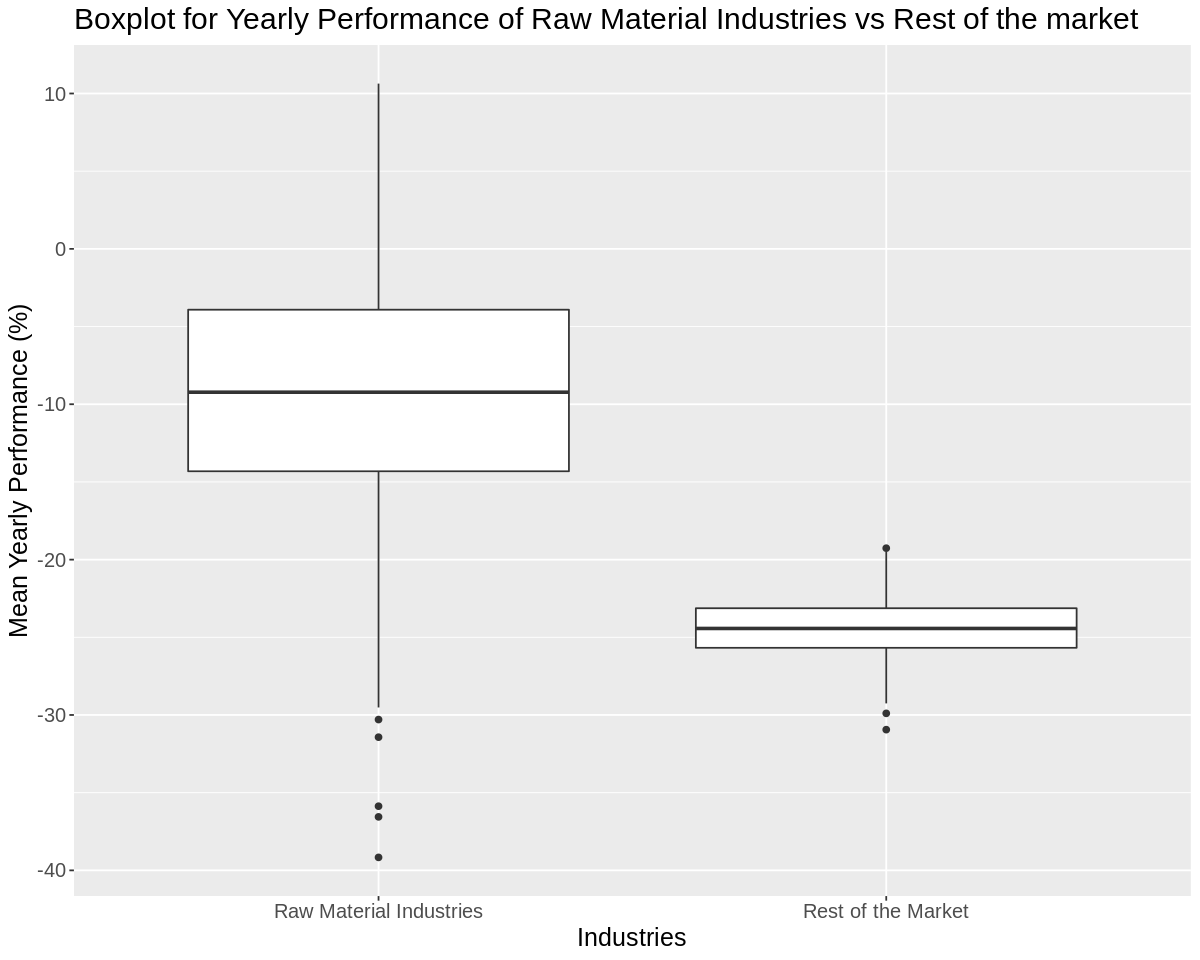

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)

#Combining Data 
dfboth<-rbind(cbind(data = "Raw Material Industries", rmc_bootstrap),
  cbind(data = "Rest of the market", nrmc_bootstrap))

#Creating Boxplot
bplot <- dfboth %>%
    ggplot()+
    geom_boxplot(aes(x = data, y = mean)) +
    labs(x = "Industries", y = "Mean Yearly Performance (%)") +
    scale_x_discrete(labels = c("Raw Material Industries", "Rest of the Market")) +
    ggtitle("Boxplot for Yearly Performance of Raw Material Industries vs Rest of the market") +
    theme(text = element_text(size = 15))
bplot

In [9]:
# Summary of the mean for yearly performance between 2 variables
summary <- dfboth %>%
    group_by(data)%>%
    summarize(f_mean = mean(mean))
summary

data,f_mean
<chr>,<dbl>
Raw Material Industries,-9.20080
Rest of the market,-24.41472


We've also included the boxplots of the bootstrap distributions to better compare the two distributions. As we observed, the raw material industries' bootstrap distribution has higher 1st quartile, 3rd quartile and higher median than that of the rest of the market. From the summary, the mean yearly performance of the raw material industries also appears to be higher than the mean for the rest of the market. These preliminary results support our suspect that the raw material industries are performing better, and we'll proceed with the hypothesis test.

# Hypothesis Testing
We perform the hypothesis test at significance level 0.05 where the null hypothesis is that there is no difference between the mean yearly performance of the raw material industries and the rest of the market; while the alternative hypothesis is that the mean yearly performance of the raw material industries is higher than that of the rest of the market.

**Setting the hypothesis**  
$m_1$ is the mean of yearly performance of the Raw Material Industries  
$m_2$ is the mean of yearly performance of Other Industries   
$H_0: m_1 - m_2 = 0$  
$H_A: m_1 - m_2 > 0$  
$\alpha$ = 0.05

In [10]:
# Samples taken from above
# Raw materials sample
head(rmc_sample)

# Other industries sample
head(nrmc_sample)

# Combined sample
head(sample_dfboth)

yearly.performance
<dbl>
38.805970
-20.348837
-68.410796
29.527559
6.199347
-22.141561


yearly.performance
<dbl>
1.944729
-92.398580
-6.966473
1.938776
26.618695
1.848049


,data,yearly.performance
,<chr>,<dbl>
1,Raw Material Industries,38.805970
2,Raw Material Industries,-20.348837
3,Raw Material Industries,-68.410796
4,Raw Material Industries,29.527559
5,Raw Material Industries,6.199347
6,Raw Material Industries,-22.141561


In [11]:
# Calculate the observed difference in means
head(sample_summary)

obs_means_diff <- sample_summary$f_mean[1] - sample_summary$f_mean[2]
obs_means_diff

data,f_mean
<chr>,<dbl>
Raw Material Industries,-9.152618
Rest of the market,-24.401879


[1] 15.24926

### Resampling

In [12]:
set.seed(9284)

# Simulate null distribution with infer package
null_model <- sample_dfboth %>%
    specify(formula = yearly.performance ~ data) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 5000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("Raw Material Industries", "Rest of the market"))

head(null_model)

replicate,stat
<int>,<dbl>
1,5.8538595
2,-2.3100384
3,-0.6913932
4,4.1817407
5,-10.9150283
6,-0.9795403


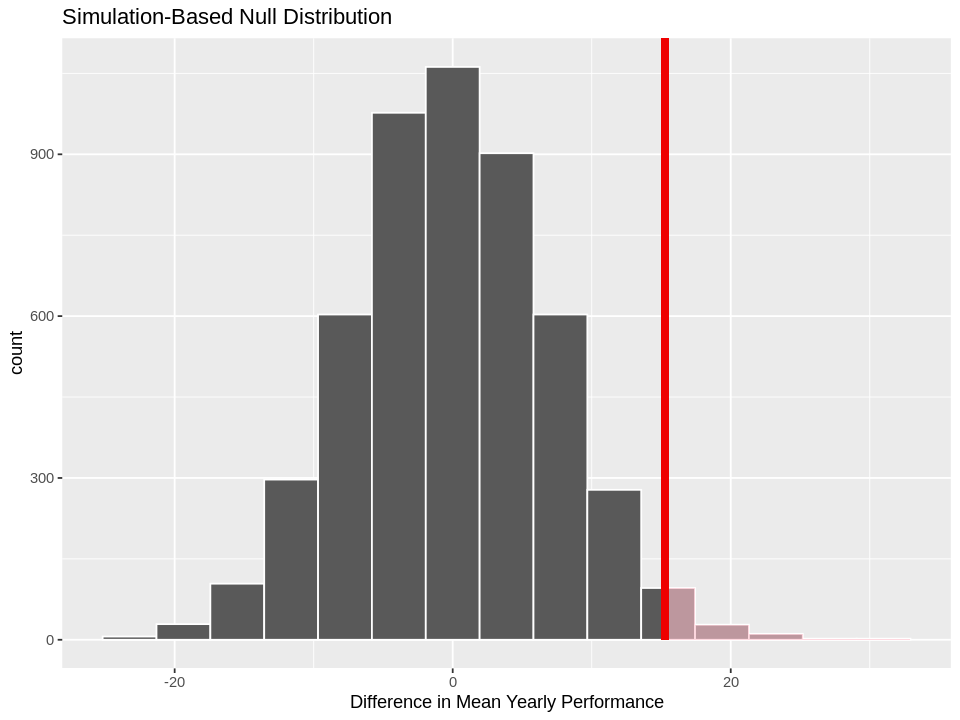

In [13]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Visualize
result_plot <- null_model %>%
    visualize() +
    shade_p_value(obs_stat = obs_means_diff, direction = "right") +
    labs(x = "Difference in Mean Yearly Performance")

result_plot

In [14]:
# Get p-value from null model
p_value <- null_model %>%
    get_p_value(obs_stat = obs_means_diff, direction = "right")

p_value

p_value
<dbl>
0.015


### Asymptotics Hypothesis Test and Confidence Interval

**Two-sample t-test**

In [15]:
# Obtain summary data frame for sample_mean, sample_var, and n
yearly_performance_summary <- sample_dfboth %>%
    group_by(data) %>%
    summarise(sample_var = var(yearly.performance), 
              n = sum(!is.na(yearly.performance)))

yearly_performance_summary

data,sample_var,n
<chr>,<dbl>,<int>
Raw Material Industries,2277.972,38
Rest of the market,1770.137,509


In [16]:
# Calculate test statistic
se <- sqrt(yearly_performance_summary$sample_var[1]/yearly_performance_summary$n[1] + yearly_performance_summary$sample_var[2]/yearly_performance_summary$n[2])
test_statistic = obs_means_diff / se

test_statistic

[1] 1.914789

$$
\nu = \frac{
    \left(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}\right)^2
}
{
\frac{s_1^4}{n_1^2(n_1-1)}+\frac{s_2^4}{n_2^2(n_2-1)}
}
,$$

We calculated the degree of freedom for our t-distribution to be 41.

In [17]:
# Calculate p-value
p_value_asymptotics <- pt(test_statistic, df = 41, lower.tail = FALSE)

p_value_asymptotics

[1] 0.0312572

**95% Confidence Interval**

In [18]:
# Performing the hypothesis test using t.test
alternative_method <- 
    tidy(t.test(x = filter(sample_dfboth, data == "Raw Material Industries")$yearly.performance, 
                y = filter(sample_dfboth, data == "Rest of the market")$yearly.performance,
                alternative = "greater"))

alternative_method

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
15.24926,-9.152618,-24.40188,1.914789,0.03122261,41.40733,1.849971,Inf,Welch Two Sample t-test,greater


### Summarizing the results

From both methods of hypothesis testing, we got 2 different p-values: 0.015 for the resampling method and 0.031 for the asymptotics method. The p-value for two cases are slightly different; however, given our significance level 0.05, we'll reject the null hypothesis in favor of the alternative hypothesis in both methods. We claim that the raw material industries indeed perform better than the rest of the market.

Our 95% confidence interval is [1.84997, $\infty$] as corresponds to our one-sided hypothesis test. This confidence interval does not include 0, which agrees with our rejection of the null hypothesis. We are 95% confident that the actual difference in means between yearly performance of the raw material industries and the rest of the industries lies within [1.84997, $\infty$].

For our project, even though both methods for hypothesis testing yields the same conclusion, the bootstrap/resampling method seems to be slightly more trustworthy if we have to choose one. This is because there are assumptions we need to make in order for the asymptotic method to work. For example, the population distribution has to be approximately normal. In our case, from the non-raw material industries sample, the distribution looks skewed yet we still proceed with the method since our sample size is relative large. We also need to make assumption about the variance being equal but from our calculation, the variances of the two samples are quite different (2277.972 versus 1770.137). On the other hand, for the resampling method, since we've take 2 samples each of size of 10% of the population, which we believe will be good representatives of the population, the method will be relatively trustworthy.

## Methods: Plan

Our dataset comes from a trustworthy source (a leading website in finance/investing) that updates their data frequently and with high precision. We have access to a large amount of data for big public companies, which make up a major share of the market; and therefore, we consider this as having access to the population of companies trading in the US market. However, we do not let the knowledge of the population influence our report. Furthermore, we also ensure that the sample sizes we take are at least 30 which is sufficient for the Central Limit Theorem to hold when we apply it. 

As we see from the graph above, the median of the yearly performance of raw material companies is higher than the non-raw material companies. The mean yearly performance of raw material companies is -1.57% as compared to -27.98% of non-raw material companies. This shows us that the question of commodity companies outperforming the market during high inflation is a valid one. However, we cannot make conclusions simply based on sample means. This is because these are still samples of only public companies, and are subject to sampling error.

Therefore, we must conduct a hypothesis test at a 5% significance level. Our null hypothesis is that the difference in the means of yearly performance of raw material and non-raw material is 0, and our alternative hypothesis is that the difference is greater than 0. This requires us to calculate the standard deviation of the difference of the two means and then do a Z-test to either reject or fail to reject our null hypothesis. 

Due to the difference in means in our preliminary data, we expect to reject our null hypothesis. If we reject our null hypothesis, it would be an indicator to financial institutions and speculators of how to allocate their investments during inflationary periods. It would also be an indicator of how economies in general have to spend a substantial part of their earnings on basic raw goods to maintain production during inflation. However, the non-commodity industries also include industries that profit from high inflation, so a further investigation could compare industries that are more specific.

## References

[1] de Soyres, F., Santacreu, A.M., & Young,H. (2022, July 15). Fiscal policy and excess inflation during Covid-19: a cross-country view. FEDS Notes. Washington: Board of Governors of the Federal Reserve System. https://doi.org/10.17016/2380-7172.3083

[2] RateInflation. (n.d.). USA Inflation Rate | Inflation Rate and Consumer Price Index. Retrieved Novemer 2, 2022 from https://www.rateinflation.com/inflation-rate/usa-inflation-rate/ 

[3] Schneider, H., & Saphir, A. (2022, November 2). Fed Jacks up interest rates again, hints at smaller increases ahead. Reuters. Retrieved November 3, 2022 from https://www.reuters.com/markets/us/fed-set-another-big-rate-hike-may-tamp-down-future-tightening-2022-11-02/ 

[4] TradingView Inc. (n.d.). Stock Screener. Retrieved October 28, 2022 from https://www.tradingview.com/screener/ 